# Confidence Intervals

Purpose: take data from multiple runs and create aggregate data that is useful for drawing conclusions

In [1]:
%matplotlib inline
import pylab
import numpy as np

Let's say we have some model of some task and we want to know how well it's doing.  Maybe we're about to change some parameter and want to to know whether changing that parameter makes the model works better.  But every time we run our model we get a slightly different result, due to random variation.

Instead of running the model once, we might run the model 3 times and take the average.  But what does that actually tell us?  It tells us the average of those 3 runs.  We don't care about those particular 3 runs: we care about what the *actual* average is: i.e. if we ran it an infinite number of times and took the average.  But that might take too long.

The goal of this notebook is to deal with exactly this problem: what can you conclude about the underlying distribution, given only samples of that distribution.

## An example sampling

Here are 3 samples from a normal distribution.  Since it's the normal distribution, we know that the actual mean if we did an infinite number of samples is 0.

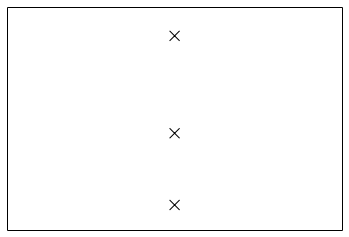

In [2]:
rng = np.random.RandomState(seed=0)

data = rng.normal(size=3)

pylab.scatter(np.zeros_like(data), data, marker='x', s=100, c='k')
pylab.xticks([])
pylab.yticks([])
pylab.show()

For this simple example, where do you think the actual mean is on this graph?  Note: this is just meant to be a typical example and I'm not doing anything tricky here like searching for a random number seed that gives horrible results (```seed=0```).

What do you think the chances are that the mean is above the largest value or below the smallest value?

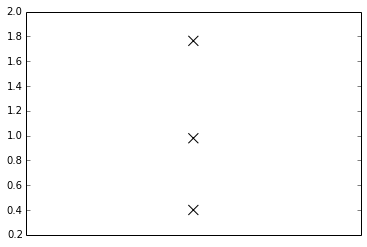

In [3]:
rng = np.random.RandomState(seed=0)

data = rng.normal(size=3)
pylab.scatter(np.zeros_like(data), data, marker='x', s=100, c='k')
pylab.xticks([])
pylab.show()

Ouch.  Even without trying to find an example where the sampling is horribly off, we have one.  If I was working with a model and I made a change and the average used to be zero, and now it's this, then I would have convinced myself that I made an improvement, when I actually haven't.

Let's see how common this is.

In [6]:
def test():
    data = rng.normal(size=3)
    if np.min(data) > 0 or np.max(data) < 0:
        return 1
    else:
        return 0
    
results = [test() for i in range(100000)]
print np.mean(results)
    

0.24912


Does this depend on the underlying distribution?

Let's try it with a uniform distribution.

In [10]:
def test():
    data = rng.uniform(size=3)
    if np.min(data) > 0.5 or np.max(data) < 0.5:
        return 1
    else:
        return 0
    
results = [test() for i in range(100000)]
print np.mean(results)
    

0.24936


Doesn't seem to depend on the distribution, which is good (because in a real situation, we don't know what the underlying distribution is!

Why doesn't it rely on the distribution?  And how does it change with the number of samples?


2 0.5083
3 0.2514
4 0.1175
5 0.0624
6 0.0324
7 0.0156
8 0.0086
9 0.0034
10 0.0022


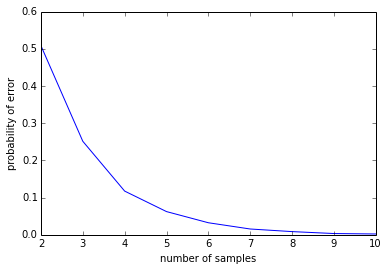

In [18]:
def test_inside_bounds(n_samples):
    data = rng.normal(size=n_samples)
    if np.min(data) > 0 or np.max(data) < 0:
        return 1
    else:
        return 0
    
Ss = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean(results))
    print S, rs[-1]

pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.show()

This is for the incredibly conservative scenario where we just take the largest and smallest sample value and only conclude that our actual mean is somewhere inbetween those values.  

Can you see why this decreases by around 50% each time?

?

This method only fails if the samples happen to all be above the mean or all be below the mean.  What are the chances of that happening?  (This also explains why it doesn't depend on the distribution!)

However, this also produces huge ranges, since the more samples you have the wider the bounds will be.



2 0.502
3 0.2448
4 0.1256
5 0.0615
6 0.0303
7 0.0152
8 0.0089
9 0.0028
10 0.0017


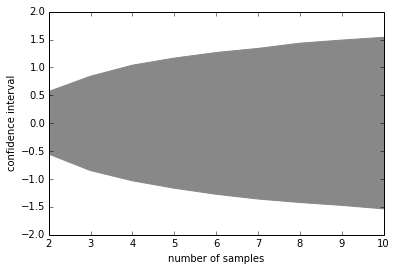

In [33]:
def test_inside_bounds(n_samples):
    data = rng.normal(size=n_samples)
    ci = np.min(data), np.max(data)
    if np.min(data) > 0 or np.max(data) < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

What could we do instead?

## Confidence Intervals

In your stats class, they dealt with this problem by computing a "confidence interval".

A 95% confidence interval says that "If you assume the actual value for whatever distribution you are sampling from is inside this range, then you will only be wrong 5% of the time".

Note that this does *not* tell you whether you're wrong in this particular case.  There's no way to know that.  But on average, this should give you a range that has the right answer in it 95% of the time.

If the assumptions hold.   This is a *big* IF.

The main one they covered in your stats class was IF the data is normally distributed, then the confidence interval is $\bar x \pm {s \over \sqrt N}t_{N-1, 95\%}$ where:
- $\bar x$ is the sample mean
- $s$ is the sample standard deviation
- $N$ is the number of samples
- $t_{N-1, 95\%}$ is the magic scaling factor that we look up on the table for Student's t-distribution.  

Here it is computed for the samples we started with

In [20]:
import scipy.stats

def normal_ci(data, p=0.95):
    t = np.array(scipy.stats.t.interval(0.95, len(data)-1))
    ci = np.mean(data)+np.std(data)/np.sqrt(len(data))*t
    return ci
print data
print normal_ci(data)

[ 1.76405235  0.40015721  0.97873798]
[-0.34082463  2.43612299]


So this says that the mean is somewhere between -0.34 and 2.44, which is correct, as the mean is actually 0!

What happens with more samples?




2 0.0722
3 0.0735
4 0.0719
5 0.0691
6 0.0673
7 0.0662
8 0.0599
9 0.0604
10 0.0603


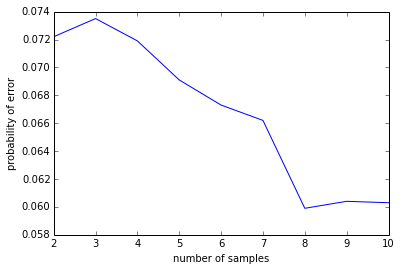

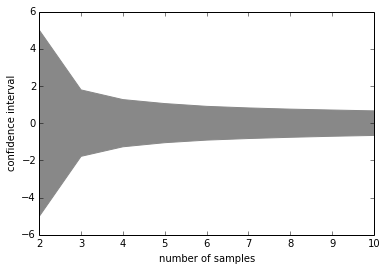

In [39]:
def test_inside_bounds(n_samples):
    data = rng.normal(size=n_samples)
    ci = normal_ci(data)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

Okay, that's better than before, but it's still a bit problematic.

Why is it wrong more than 5% of the time?

We're fine on the assumption that it's normally distributed data...

But there's another assumption: that you have enough samples.  What is enough?


5 0.0642
10 0.0651
15 0.0611
20 0.0512
25 0.0543
30 0.052
35 0.0523
40 0.0506


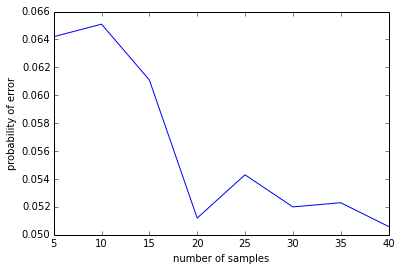

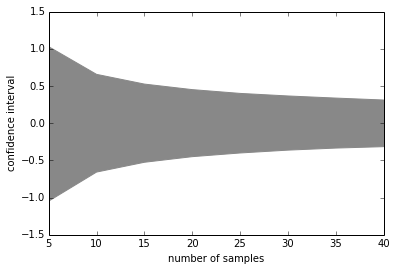

In [38]:
def test_inside_bounds(n_samples):
    data = rng.normal(size=n_samples)
    ci = normal_ci(data)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()   
pylab.title('Normal distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

General rule of thumb: Need about 20 samples to do a 95% confidence interval

Why?  What would the rule of thumb be for an 80% confidence interval?



In [44]:
def needed_samples(p=0.95):
    return 1.0 / (1-p)

print 0.95, needed_samples(p=0.95)
print 0.8, needed_samples(p=0.8)

0.95 20.0
0.8 5.0


The idea here is that you really should have enough samples that you should expect one to be outside the range.  If you don't have any, then it's very hard to figure out where the range should be.

## Other distributions

But the algorithm described only works if the data is normally distributed.  What happens if it isn't?

Uniform distribution

5 0.0835
10 0.0618
15 0.0588
20 0.06
25 0.0511
30 0.0538
35 0.0536
40 0.0541


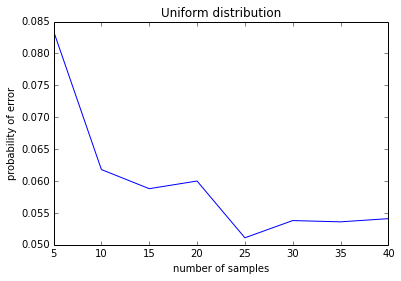

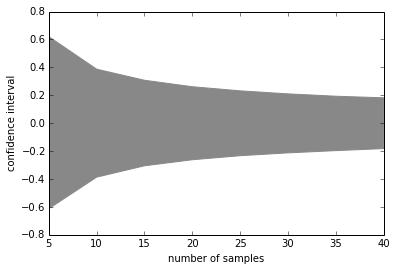

In [47]:
def test_inside_bounds(n_samples):
    data = rng.uniform(-1,1, size=n_samples)
    ci = normal_ci(data)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.title('Uniform distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

5 0.064
10 0.1089
15 0.0328
20 0.0459
25 0.0398
30 0.0429
35 0.0403
40 0.0369


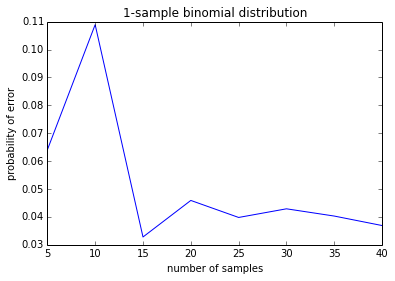

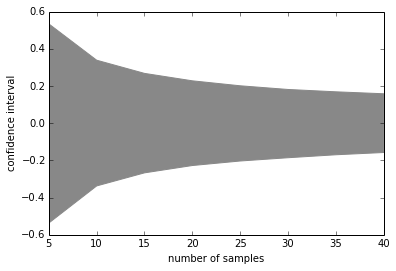

In [48]:
def test_inside_bounds(n_samples):
    data = rng.binomial(1, p=0.5, size=n_samples)-0.5
    ci = normal_ci(data)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.title('1-sample binomial distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

5 0.4343
10 0.333
15 0.2876
20 0.2426
25 0.2132
30 0.1998
35 0.1862
40 0.1762


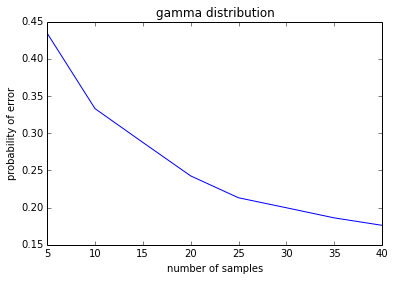

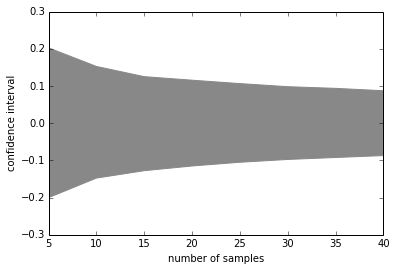

In [49]:
def test_inside_bounds(n_samples):
    data = rng.gamma(0.1, size=n_samples)-0.1
    ci = normal_ci(data)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.title('gamma distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

It's not too bad for other distributions, unless they're really pathological.  Still, it doesn't get the expected 5% error unless all the assumptions hold: normally distributed data and enough samples (~50 to be safe).



## Other statistics

Oh, and one other assumption: it only works for computing the mean.  

What if I want a confidence interval on my standard deviation?  Or on the median?  Or on the regression coefficient?  Or something more complicated than that?

There are analytical results for a few of these, but we'd really like something that works for whatever statistic I want to do.  This is especially the case for situations where we're looking at human data and it's the distribution of performance that matters, not just the mean.


## Bootstrap Confidence Intervals

The term "bootstrap" refers to a whole family of algorithms that involve re-sampling from the samples you already have to approximate the underlying distribution.

The core idea for a bootstrap confidence interval is to simulate the process of running your experiment an infinite number of times.  However, we can't actually re-run the experiment.  Instead, what we do is to take your sample data and pretend that is the *exact* distribution of results.  So we can simulate re-running the experiment by sampling from the results we already have.

In other words, if I have 20 data points, I can estimate what would happen if I re-ran that full experiment once by just sampling 20 values from those 20 data points.  This, of course, has to be sampling *with replacement*, otherwise I'd just get the original data back again.  So I can repeat the experiment and do that same measure on it (say, compute the mean).

Just doing it once doesn't tell me what would happen if I did it an infinite number of times.  So let's do it over and over again.  The general number is 3000 (which is pretty close to infinity).  Now you have 3000 computations of the mean.  To determine your range, sort them, throw out the bottom 2.5% and the top 2.5%, and you're left with the 95% confidence interval.



In [51]:
def bootstrap_ci(data, func, n=3000, p=0.95):
    index = int(n*(1-p)/2)

    samples = np.random.choice(data, size=(n, len(data)))
    try:
        r = func(samples, axis=1)  # if the function supports axis
    except TypeError:
        r = [func(s) for s in samples]  # otherwise do it the slow way
    r.sort()
    return r[index], r[-index]

5 0.166
10 0.094
15 0.089
20 0.075
25 0.067
30 0.058
35 0.062
40 0.063


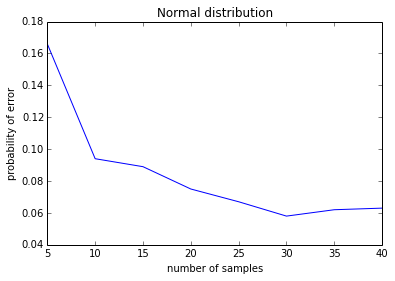

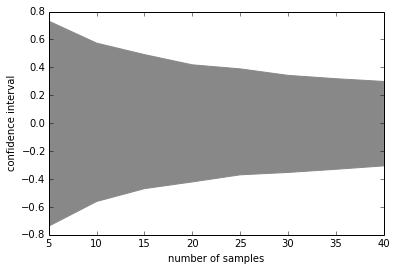

In [54]:
def test_inside_bounds(n_samples):
    data = rng.normal(size=n_samples)
    ci = bootstrap_ci(data, np.mean)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(1000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()   
pylab.title('Normal distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

5 0.0618
10 0.0214
15 0.0681
20 0.0421
25 0.0458
30 0.0432
35 0.0514
40 0.0401


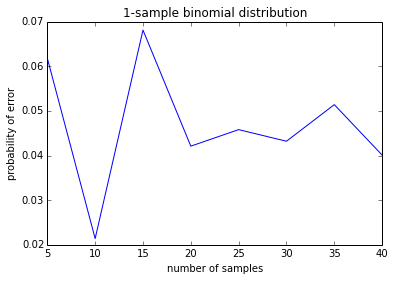

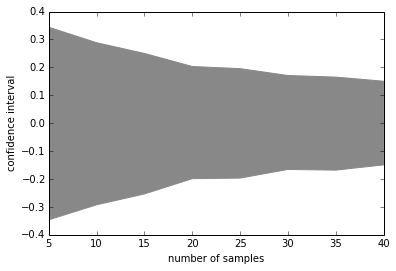

In [56]:
def test_inside_bounds(n_samples):
    data = rng.binomial(1, p=0.5, size=n_samples)-0.5
    ci = bootstrap_ci(data, np.mean)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.title('1-sample binomial distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

5 0.4677
10 0.3486
15 0.2787
20 0.237
25 0.2023
30 0.1922
35 0.1803
40 0.1613


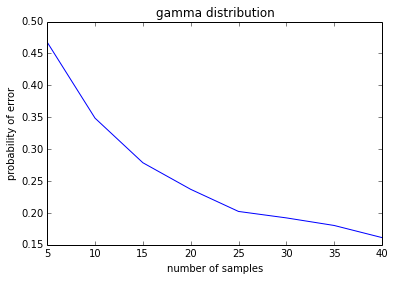

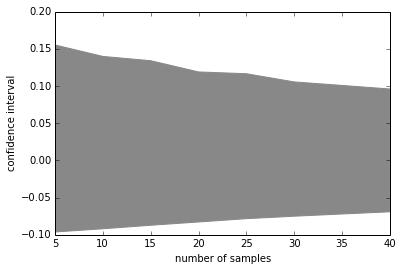

In [57]:
def test_inside_bounds(n_samples):
    data = rng.gamma(0.1, size=n_samples)-0.1
    ci = bootstrap_ci(data, np.mean)
    if ci[0] > 0 or ci[1] < 0:
        return 1, ci
    else:
        return 0, ci
    
Ss = [5, 10, 15, 20, 25, 30, 35, 40]
rs = []
mins = []
maxs = []
for S in Ss:
    results = [test_inside_bounds(n_samples=S) for i in range(10000)]
    rs.append(np.mean([r[0] for r in results]))
    mins.append(np.mean([r[1][0] for r in results]))
    maxs.append(np.mean([r[1][1] for r in results]))
    print S, rs[-1]

    
pylab.figure()    
pylab.title('gamma distribution')
pylab.plot(Ss, rs)
pylab.xlabel('number of samples')
pylab.ylabel('probability of error')
pylab.figure()    
pylab.fill_between(Ss, mins, maxs, color='#888888')
pylab.xlabel('number of samples')
pylab.ylabel('confidence interval')
pylab.show()

The bootstrap CI is worse for normally distributed data (unsurprising, since that's exactly the assumption the normal approach makes), but better for other distributions.  

Also, notice that for the gamma distribution, the confidence interval is non-symmetric!  This highlights another problem with the standard approach: it always gives symmetric distributions.  The bootstrap does not.

However, also note that all these methods are having a hard time with the gamma distribution, and are giving errors much more than 5% of the time.  Horrible distributions are horrible.